# Libraries

In [2]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import imageio.v2 as io 

from skimage.transform import resize

import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Parameters

In [14]:
path="F:/DeepLearning/IPCV (Diode)/Datasets/DIODE_FULL"
size = (384, 512)

# Create Csv

In [15]:
# save dataset
def create_df_ipcv_diode(path,path_dst='../Csv/',name='path_images'):
    folder=os.listdir(path)
    df = pd.DataFrame(columns=['scene','scan','name','path_rgb','path_depth','path_mask'])
    for scene in folder:
        scans=os.listdir(path+'/'+scene)
        for scan in scans:
            files=os.listdir(path+'/'+scene+'/'+scan)
            for file in files:
                if file[-4:]=='.png':
                    path_base=path+'/'+scene+'/'+scan+'/'+file[:-4]
                    df.loc[len(df)]={'scene':str(scene),'scan':scan,'name':file[:-4]
                                    ,'path_rgb': str(path_base+'.png'),
                                    'path_depth': str(path_base+'_depth.npy'),
                                    'path_mask':str(path_base+'_depth_mask.npy')}
    print(df.head(1))
    df.to_csv(path_dst+name+'.csv',index=False)

# creazione dataset
create_df_ipcv_diode(path,path_dst="F:/DeepLearning/IPCV (Diode)/Csv")

         scene        scan                         name  \
0  scene_00000  scan_00000  00000_00000_indoors_020_050   

                                            path_rgb  \
0  F:/DeepLearning/IPCV (Diode)/Datasets/DIODE_FU...   

                                          path_depth  \
0  F:/DeepLearning/IPCV (Diode)/Datasets/DIODE_FU...   

                                           path_mask  
0  F:/DeepLearning/IPCV (Diode)/Datasets/DIODE_FU...  


In [4]:
# Definisci le trasformazioni che desideri applicare
rgb_transformations = transforms.Compose([
    transforms.Resize(size),  # Riduci le dimensioni dell'immagine
    transforms.ToTensor(),  # Converti in tensore
    transforms.Lambda(lambda x: x.float()),  # Converti in float
    transforms.Lambda(lambda x: x.to(device))  # Sposta il tensore sulla GPU
])

depth_map_transformations = transforms.Compose([
    transforms.Resize(size),  # Riduci le dimensioni della mappa di profondità
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.float()),  # Converti in float
    transforms.Lambda(lambda x: x.to(device))  # Sposta il tensore sulla GPU
])

In [ ]:
#Data augmentation operations
rgb_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

rgbd_augmentation = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip()
])

In [5]:
def train_val_test_split(csv_path, train_scenes = ['scene_00000', 'scene_00001','scene_00006','scene_00004'],
                           val_scenes =['scene_00002', 'scene_00003'], test_scenes = ['scene_00005']):
    df = pd.read_csv(csv_path)
    train_df = df.loc[df['scene'].isin(train_scenes)]
    val_df = df.loc[df['scene'].isin(val_scenes)]
    test_df = df.loc[df['scene'].isin(test_scenes)]
    path_dst = '/kaggle/working/'
    train_df.to_csv(path_dst+'path_train'+'.csv',index=False)
    val_df.to_csv(path_dst+'path_val'+'.csv',index=False)
    test_df.to_csv(path_dst+'path_test'+'.csv',index=False)


In [6]:
csv_path="/kaggle/working/path_images.csv"
train_val_test_split(csv_path)

In [7]:
class CustomDataset:
    def __init__(self, csv_path, perc_dataset=1, transform = None, target_transform = None):
        self.df = pd.read_csv(csv_path)
        self.df = self.df.iloc[:int(len(self.df)*perc_dataset)]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return int(len(self.df))
    
    def __getitem__(self, idx):        
        img_rgb = Image.open(self.df.loc[idx, 'path_rgb'])
        img_rgbd = np.load(self.df.loc[idx, 'path_depth'])
        
        # Apply the transformations to the image
        if self.transform:
            img_rgb = self.transform(img_rgb)
        if self.target_transform:
            img_rgbd = self.target_transform(img_rgbd)

        return img_rgb, img_rgbd
        
csv_train_path = "/kaggle/working/path_train.csv"
csv_val_path = "/kaggle/working/path_val.csv"
csv_test_path = "/kaggle/working/path_test.csv"


train_set = CustomDataset(csv_train_path, perc_dataset=0.1)
val_set = CustomDataset(csv_val_path, perc_dataset=0.1, transform=rgb_transformations, target_transform=depth_map_transformations)
test_set = CustomDataset(csv_test_path, perc_dataset=0.1, transform=rgb_transformations, target_transform=depth_map_transformations)

augmented_train_set = torch.utils.data.Dataset(train_set, transform = rgb_augmentation, transform = rgbd_augmentation)





# creazione di train_loader e val_loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, shuffle=False)


# Show dataset

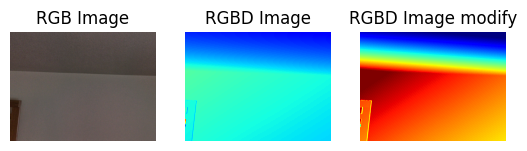

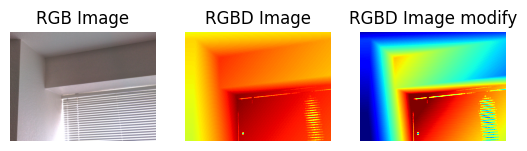

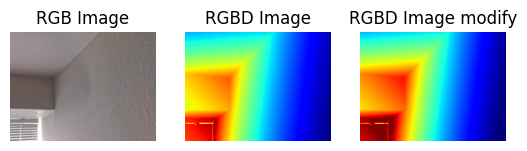

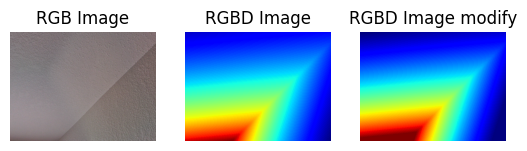

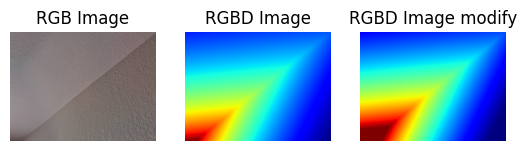

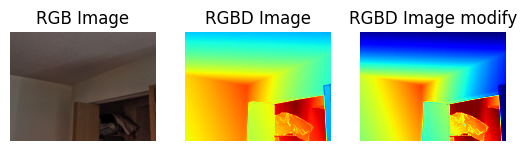

11 3 1


In [8]:
# print corretta, da implementare solo l'offset
def print_dataset(train_loader,rows = 6,offset=0):
    count = 0
    for batch_idx, (img_rgb, img_rgbd) in enumerate(train_loader):     # Iterare sui batch del train_loader
        for sample_idx in range(img_rgb.size(0)):         # Iterare sui singoli campioni nel batch
            img_rgb_np = img_rgb[sample_idx].permute(1,2,0).cpu().numpy()
            img_rgbd_np = img_rgbd[sample_idx].permute(1,2,0).cpu().numpy()

            fig, axes = plt.subplots(1, 3)
            axes[0].imshow(img_rgb_np)
            axes[0].axis('off')
            axes[0].set_title("RGB Image")
            axes[1].imshow(img_rgbd_np, cmap='jet')
            axes[1].axis('off')
            axes[1].set_title("RGBD Image")

            # Calculate the 90th percentile
            percentile_95 = np.percentile(img_rgbd_np, 98)
            percentile_5 = np.percentile(img_rgbd_np, 2)
            img_rgbd_np_tmp=np.copy(img_rgbd_np)
            img_rgbd_np_tmp[img_rgbd_np_tmp >= percentile_95] = percentile_95
            img_rgbd_np_tmp[img_rgbd_np_tmp <= percentile_5] = percentile_5
            axes[2].imshow(img_rgbd_np_tmp, cmap='jet')
            axes[2].axis('off')
            axes[2].set_title("RGBD Image modify")
            plt.show()
        
            count +=1
            if count == rows:
                break
        if count == rows:
            break

print_dataset(train_loader,rows = 6)
print(len(train_loader), len(val_loader), len(test_loader))

# Modello e iperparametri

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models

class ImageConverter(nn.Module):
    def __init__(self):
        super(ImageConverter, self).__init__()
        # Load the pre-trained DenseNet-121 model
        pretrained_model = models.densenet121(pretrained=True)
        
        # Remove the last layer (classifier) of the DenseNet-121 model
        self.encoder = nn.Sequential(*list(pretrained_model.children())[:-1])
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.4),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.1),            
            nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(inplace = True),
            nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Training

In [10]:

model = ImageConverter()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
num_epochs = 3
running_loss=0

if torch.cuda.is_available():
    model.cuda()

list_loss_train=[]
list_loss_val=[]
print ("Training...")
    
for epoch in range(num_epochs):
    
    #training
    train_loss = 0
    for batch, data in enumerate(train_loader):
        images, img_rgbd = data
        model.train()
        # forward pass
        outputs = model(images)
        
        #calcolo loss
        loss = criterion(outputs, img_rgbd)
        train_loss += loss
        
        #optimizer zero_grad
        optimizer.zero_grad()
        
        #loss backward
        loss.backward()
        
        
        optimizer.step()#optimizer step
        
        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_loader)
    list_loss_train.append(float(train_loss))
    # print (len(train_loader))    
    
    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy 
    val_loss = 0 
    model.eval()
    with torch.inference_mode():
        for batch, data in enumerate(val_loader):
            images, img_rgbd = data
            # 1. Forward pass
            val_outputs = model(images)           
            # 2. Calculate loss (accumatively)
            val_loss += criterion(val_outputs, img_rgbd) # accumulatively add up the loss per epoch
        
        # Calculations on test metrics need to happen inside torch.inference_mode()        
        val_loss /= len(val_loader)# Divide total test loss by length of test dataloader (per batch)        
        list_loss_val.append(float(val_loss))# print (len(val_loader))
    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Val loss: {val_loss:.5f}")


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 75.1MB/s]


Training...

Train loss: 1.99220 | Val loss: 1.73031

Train loss: 0.97153 | Val loss: 1.22389

Train loss: 0.59578 | Val loss: 0.76375


# Shows

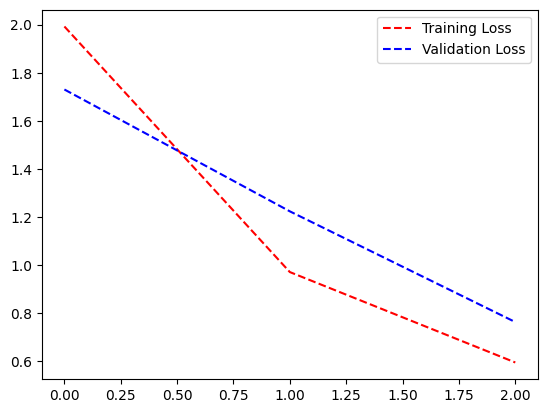

In [11]:
def print_epoch(epoch_loss_train, epoch_loss_val):
    plt.plot(range(len(epoch_loss_train)),epoch_loss_train,'r--', label = 'Training Loss')
    plt.plot(range(len(epoch_loss_val)), epoch_loss_val, 'b--', label='Validation Loss')
    plt.legend()
    plt.show()

print_epoch(list_loss_train, list_loss_val)

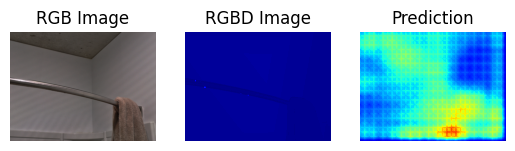

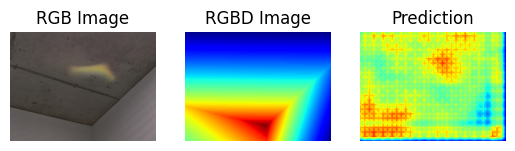

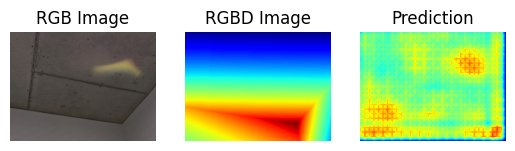

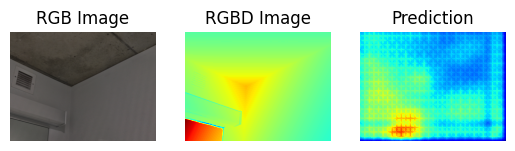

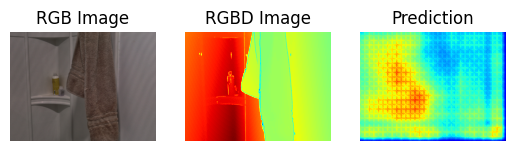

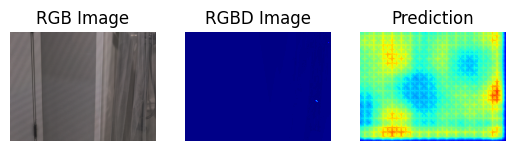

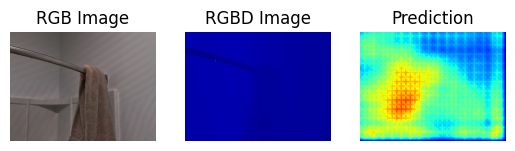

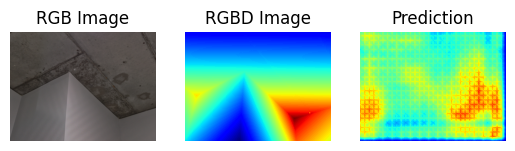

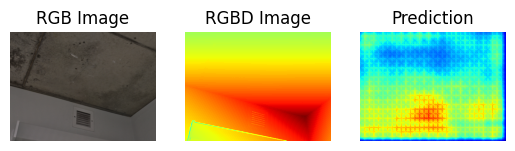

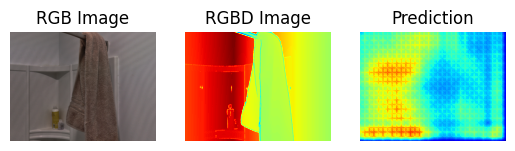

In [12]:
# print corretta, da implementare solo l'offset
def print_dataset_pred(loader,rows = 6,offset=0):
    count = 0
    # Iterare sui batch del train_loader
    for batch, data in enumerate(loader):
        img_rgb, img_rgbd = data

        # Iterare sui singoli campioni nel batch
        for sample_idx in range(img_rgb.size(0)):
        
            # Convertire i tensori in array NumPy
            img_rgb_np = img_rgb[sample_idx].permute(1,2,0).cpu().numpy()
            img_rgbd_np = img_rgbd[sample_idx].permute(1,2,0).cpu().numpy()

            # Visualizzare le immagini utilizzando matplotlib
            fig, axes = plt.subplots(1, 3)
            axes[0].imshow(img_rgb_np)
            axes[0].axis('off')
            axes[0].set_title("RGB Image")
            

            model.eval()
            with torch.inference_mode():
                pred=model(img_rgb)
            result=pred[sample_idx].permute(1,2,0).cpu().detach().numpy()
            
            axes[1].imshow(img_rgbd_np, cmap='jet')
            axes[1].axis('off')
            axes[1].set_title("RGBD Image")
            
            
            axes[2].imshow(result, cmap='jet')
            axes[2].axis('off')
            axes[2].set_title("Prediction")
             
            plt.show()
        
            count +=1
            if count == rows:
                break
    
        if count == rows:
            break

print_dataset_pred(val_loader,rows = 10)


# Task

- Data argumentation : smoothing + flip + modifiche HSV con passaggio di parametri (Immagin e label come nel flip)
    - def DataArgumentation(dataset,params_argumentation) return dataset
    - la classe custom dataset gia ha i tensori, i tensori che non possono essere modificati , quindi modificare CustomDataset in modo che passi valori numpy
    - la nostra funzione deve ritornare una classe simile a custom dataset con le immagini modificate
- Splitting : divisione in train e validation e test, considered normalization valori
    - def Conversion(dataset/img , type_conversion) return dataset, conersione che ritorna 
    - Codice per la normalizzazione dei valori sulla label in modo che i valori di tutto il dataset variano in un intervallo
    - implementazione fak simile codice trovato su internet
    - divisione con skilearn del dataset , dovremo lavorare con i tensori
- Validation: addestrare e validare il modello con una funzione, provare 2-3 loss differenti anche una custom
    - implementare codice validation
    - vedere le 2-3 fuzioni di loss piu utilizzate confrontare
    - stilare un elenco di parametri
    - studiare/implementare dropout, batch normalization ....
    - prendere un imagenet o altro come encoder (TRANSFER LEARNING)
- Risultati : Stampa a video risultati e valori di similarità
    - stampa curva della loss, considerare che possono arrivare piu curve di loss e propaghiamo solo su una o su tutte
    - stampa a video dei risultati del test e validation
    - implementare una funzione che ti mostra tipo il 10% dei punti piu errati che ci sono


# Modifiche fatte
- cambiato il modo in cui sono scritte la __init__ e la __getitem__ in modo tale che ci sia sempre un solo sample del dataset nella classe e non una lista
- ho implementato le trasformazioni (per ora solo la trasformazione in tensore e lo spostamento al device) nella __getitem__. Se si vuole aggiunere qualche altra operazione di data augmentation basta inserirla nelle trasformazioni definite, ma prima della trasformazione in tensore.
- Ho cambiato dei __permute__ perchè così andavano bene con la transform che faccio (usa __ToTensor__, che fa cose diverse da quella usata in precedenza). Ho tolto __astype(int)__ perchè con queste modifiche non serviva per stampare bene a video le immagini.
- ho implementato lo splitting del dataset in _training_set_ _validation_set_ e in _test_set_. Ho implementato il val_loader e ho modificato la __validation_function__ mettendo __model.eval()__ e __with torch.inference_mode__ giusto per vedere come va il modello 
- ho implementato daccapo il training loop perché con le 2 funzioni non andava (probabilmente un errore nei parametri passati)